In [0]:
# On Oxford-IIIT Pet Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

--2019-11-05 15:00:37--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  71.6MB/s    in 11s     

2019-11-05 15:00:48 (71.3 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2019-11-05 15:00:50--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  59.9MB/s    in 0.3s    

2019-11-05 15:00:50 (59.9 MB/s)

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []                                                              # consists of raw images
    batch_y = []                                                              # consists of masks
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))                                      # resize the masks into (256*256) and convert into array


        #preprocess the mask 
        mask[mask >= 2] = 0                                                   # convert the mark intensities into two classes
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)                                                  # resize the raw image and convert into array

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)                                  # if gray scale image, convert into rgb image of 3 channels having same intensity

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.                                       # normalize all raw images
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)                                    # convert masks into 3rd dimension

    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]                                          # 95:5 train-test split ratio
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

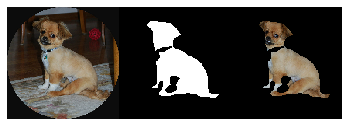

In [6]:
plt.axis('off')
img = x[1]
msk = y[1].squeeze()                                                       # remove single-dimensional entries from the shape of image
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [0]:
# function for defining intersection over union metric
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [9]:
model = unet()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()









i= 1 loss= 0.5582881020084364 val_loss= 0.4531567828221755 mean_iou= 0.13241983143665104 val_mean_iou= 0.44303247332572937


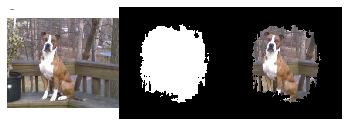

i= 2 loss= 0.45286673783711645 val_loss= 0.4122927649454637 mean_iou= 0.42325092338506115 val_mean_iou= 0.46199889887462964


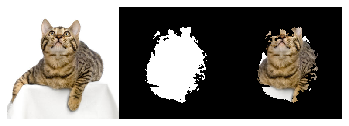

i= 3 loss= 0.43670886183438234 val_loss= 0.4330075681209564 mean_iou= 0.45769935104672765 val_mean_iou= 0.4515766609798778


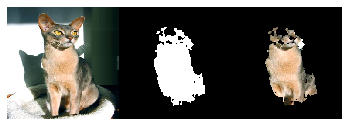

i= 4 loss= 0.4045981537533677 val_loss= 0.3575575297529047 mean_iou= 0.5010177047591503 val_mean_iou= 0.5062530203299089


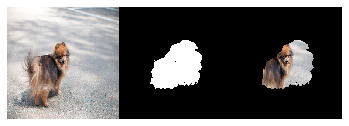

i= 5 loss= 0.3640885585791444 val_loss= 0.3284446055238897 mean_iou= 0.5533642298350595 val_mean_iou= 0.5973322120579806


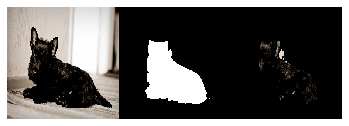

i= 6 loss= 0.32695716360932614 val_loss= 0.30424855784936383 mean_iou= 0.6083230962764182 val_mean_iou= 0.6444073265249078


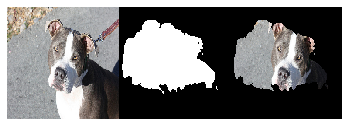

i= 7 loss= 0.2945789980561766 val_loss= 0.2638428671793504 mean_iou= 0.646389805699048 val_mean_iou= 0.6981934959238226


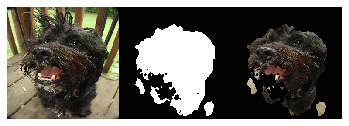

i= 8 loss= 0.2724864902697742 val_loss= 0.26838347722183575 mean_iou= 0.6775631429670064 val_mean_iou= 0.650562194260684


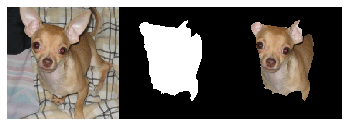

i= 9 loss= 0.25522814180753 val_loss= 0.23464795676144687 mean_iou= 0.6999719249059076 val_mean_iou= 0.6952853419563987


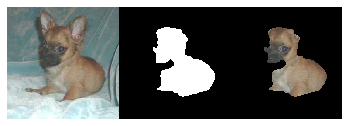

i= 10 loss= 0.23058732221387837 val_loss= 0.24721812118183484 mean_iou= 0.7265990447235978 val_mean_iou= 0.6990399739959023


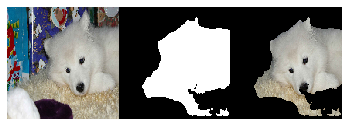

i= 11 loss= 0.21755605595841254 val_loss= 0.24921459636904977 mean_iou= 0.7436584310444523 val_mean_iou= 0.719381267374212


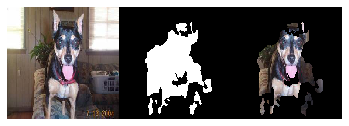

i= 12 loss= 0.2097067160693478 val_loss= 0.2548251436515288 mean_iou= 0.7519592955776545 val_mean_iou= 0.7385442527857694


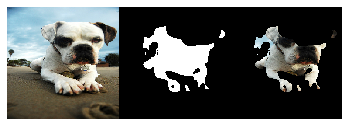

i= 13 loss= 0.19373326609123787 val_loss= 0.24460027841004459 mean_iou= 0.7676156517033164 val_mean_iou= 0.7076309323310852


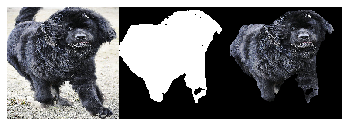

i= 14 loss= 0.1784312913543013 val_loss= 0.18900488317012787 mean_iou= 0.7854213951385185 val_mean_iou= 0.765295760198073


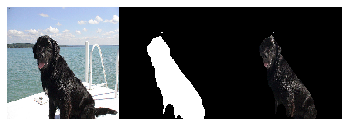

i= 15 loss= 0.17005503531460348 val_loss= 0.23082372004335577 mean_iou= 0.7927467931895495 val_mean_iou= 0.7237726341594349


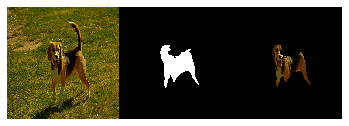

i= 16 loss= 0.16033819518541093 val_loss= 0.18951126526702533 mean_iou= 0.8055630886935752 val_mean_iou= 0.7676030072298917


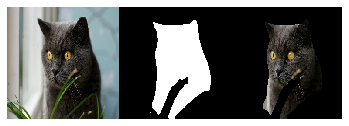

i= 17 loss= 0.15130634105777088 val_loss= 0.20237131145867435 mean_iou= 0.8162097805711233 val_mean_iou= 0.7446915669874712


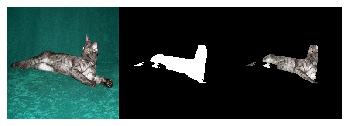

i= 18 loss= 0.14638859775240562 val_loss= 0.20732578906145963 mean_iou= 0.8210109235489205 val_mean_iou= 0.7525821436535228


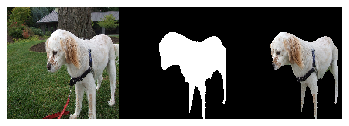

i= 19 loss= 0.13839646292739807 val_loss= 0.20145504041151566 mean_iou= 0.8278774156418021 val_mean_iou= 0.7576555555517023


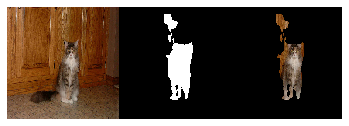

i= 20 loss= 0.12935662116498164 val_loss= 0.22638424147259106 mean_iou= 0.8389282172129034 val_mean_iou= 0.7418529174544595


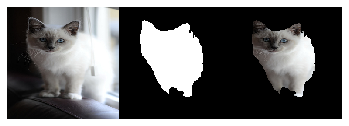

i= 21 loss= 0.1276776131293545 val_loss= 0.22389011762358926 mean_iou= 0.8415855622454865 val_mean_iou= 0.7489097497679971


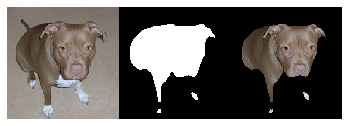

i= 22 loss= 0.1215882193824472 val_loss= 0.22578013891523535 mean_iou= 0.8494886456559237 val_mean_iou= 0.756019798192111


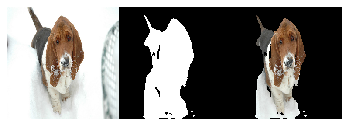

i= 23 loss= 0.11568630684048073 val_loss= 0.21389725939794021 mean_iou= 0.8544372605950865 val_mean_iou= 0.760587605563077


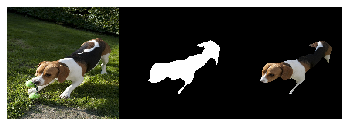

i= 24 loss= 0.11271771781792923 val_loss= 0.2032186822457747 mean_iou= 0.8589370503817519 val_mean_iou= 0.7752382267605175


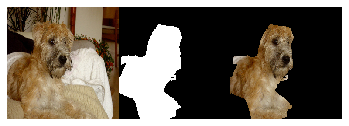

i= 25 loss= 0.10962509186980932 val_loss= 0.241641413081776 mean_iou= 0.8615022160146879 val_mean_iou= 0.7451468055898492


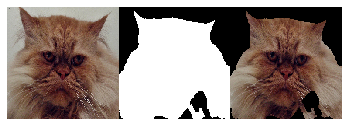

i= 26 loss= 0.10378893420576504 val_loss= 0.22878004068678076 mean_iou= 0.8676292194079046 val_mean_iou= 0.7550782398744063


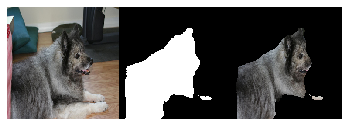

i= 27 loss= 0.10170355861045455 val_loss= 0.25117477639154956 mean_iou= 0.8707526557521733 val_mean_iou= 0.7367575439539823


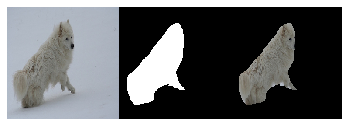

i= 28 loss= 0.09873367607865703 val_loss= 0.23340715874325146 mean_iou= 0.8743253143410704 val_mean_iou= 0.7736845341595736


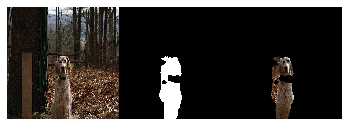

i= 29 loss= 0.09523193970254568 val_loss= 0.20424228635701266 mean_iou= 0.8761412762615779 val_mean_iou= 0.7558160695162687


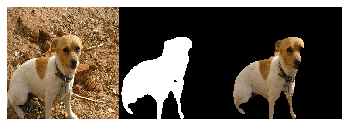

i= 30 loss= 0.0933910237463642 val_loss= 0.2585034356875853 mean_iou= 0.8799927392506708 val_mean_iou= 0.7694240754300897


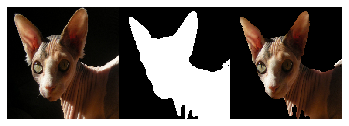

In [11]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
!wget https://making-the-web.com/sites/default/files/clipart/133325/dog-images-133325-4356347.jpg -O test.jpg

--2019-11-05 15:29:17--  https://making-the-web.com/sites/default/files/clipart/133325/dog-images-133325-4356347.jpg
Resolving making-the-web.com (making-the-web.com)... 104.27.172.57, 104.27.173.57, 2606:4700:30::681b:ad39, ...
Connecting to making-the-web.com (making-the-web.com)|104.27.172.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34659 (34K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  33.85K  --.-KB/s    in 0.007s  

2019-11-05 15:29:17 (4.78 MB/s) - ‘test.jpg’ saved [34659/34659]



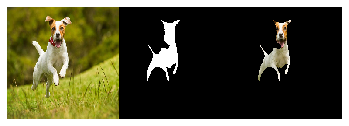

In [15]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.                                    # resizing, converting into array and normalizing the test image
raw = raw[:,:,0:3]                                                             

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))                                   # convert into (3,256,256)

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()